In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]=""
from mnist_model import generator,discriminator
import utils

In [12]:
params = dict(
    batch_size = 100,
    seed = 1234,
    z_dim = 100,
    x_dim = 784,
    reg_w = 0.,
    lr = 2e-4
)
rng = np.random.RandomState(params['seed'])  # seed labels

In [13]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels
# trainx = 2.*trainx-1.
trainx = np.reshape(trainx,[-1,28,28,1])
testx = np.reshape(testx,[-1,28,28,1])
testy.astype(np.int32)
trainy.astype(np.int32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


array([7, 3, 4, ..., 2, 1, 2], dtype=int32)

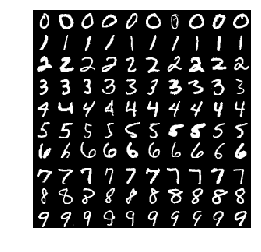

In [14]:
labeled =10
trainx_unl = trainx.copy()
inds = np.random.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

show_digits(trainx[:1000])
plt.show()

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
train_triger= iterator.make_initializer(train_dataset)
test_triger= iterator.make_initializer(test_dataset)

In [16]:
def lenet(x,training_pl):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x,32,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.conv2d(x,64,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.flatten(x)
        x = tf.layers.dense(x,1024,activation=tf.nn.relu)
        x = tf.layers.dropout(x,rate=0.4,training=training_pl)
        x = tf.layers.dense(x,10)
        return x

In [17]:
next_label

<tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=uint8>

In [18]:
label = tf.cast(next_label,tf.int64)
training_pl  = tf.placeholder(tf.bool,[])
logits = lenet(next_element,training_pl)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=label)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(xloss)

correct_prediction = tf.equal(tf.argmax(logits,1),label)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [25]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [26]:
sess.run(train_triger)
for i in range(8001):
    xl,_,acc = sess.run([xloss,train_op,accuracy],feed_dict={training_pl:True})
    if i % 1000 == 0:
        sess.run(test_triger)
        test_acc = 0
        for n in range(nr_batch_test):
            test_acc  += sess.run(accuracy,feed_dict={training_pl:False})
        test_acc /= nr_batch_test
        print("Step: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(i, xl, acc * 100,test_acc*100))
        sess.run(train_triger)



Step: 0, xloss: 2.31351, training acc: 9.00%, test acc: 39.97%
Step: 1000, xloss: 0.00000, training acc: 100.00%, test acc: 84.38%
Step: 2000, xloss: 0.00000, training acc: 100.00%, test acc: 84.26%
Step: 3000, xloss: 0.00000, training acc: 100.00%, test acc: 85.94%
Step: 4000, xloss: 0.00000, training acc: 100.00%, test acc: 86.14%
Step: 5000, xloss: 0.00000, training acc: 100.00%, test acc: 86.27%
Step: 6000, xloss: 0.00000, training acc: 100.00%, test acc: 86.49%
Step: 7000, xloss: 0.00000, training acc: 100.00%, test acc: 86.55%
Step: 8000, xloss: 0.00000, training acc: 100.00%, test acc: 86.73%
